In [1]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    df['gap_negative'] = df['time_to_order_seconds'] < 0
    df['is_midnight_session'] = df['session_end_hour'].isin([0, 1, 2, 3])
    df['order_during_business_hours'] = df['order_hour'].between(9, 18)
    
    df['hour_diff'] = df['session_end_hour'] - df['order_hour']

    df['order_time_fraction'] = df[order_time_col].dt.hour * 3600 + df[order_time_col].dt.minute * 60 + df[order_time_col].dt.second
    df['order_time_fraction'] /= 86400  # нормировка по числу секунд в сутках

    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# 1) Загрузка
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr = create_time_features(tr)
tst = create_time_features(tst)

# удаляем исходные метки времени
tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

# 2) Первый уровень: rule-based фильтр
threshold_hard = -2000
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

# 3) приводим object → category для ВСЕХ нужных колонок
#    это должны быть колонки из tr.select_dtypes(object) и session_end_time_of_day и т.п.
cat_cols = tr.select_dtypes(include=['object']).columns.tolist() + [
    'order_time_of_day', 'session_end_time_of_day'
]
cat_cols = list(set(cat_cols))  # убрать дубли

for col in cat_cols:
    # ТОЛЬКО если колонка есть в датафрейме
    if col in tr.columns:
        tr[col]  = tr[col].astype('category')
        tst[col] = tst[col].astype('category')

# 4) Разделяем на «сложные» и «очевидные» кейсы
mask = tr['hard_call'] == 0
X_soft = tr[mask]
y_soft = target[mask]

# 5) train/val split для «сложных»
X_train, X_val, y_train, y_val = train_test_split(
    X_soft, y_soft, test_size=0.2, stratify=y_soft, random_state=42
)

# 6) Dataset для LGBM
train_data = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=cat_cols
)
val_data = lgb.Dataset(
    X_val, label=y_val,
    categorical_feature=cat_cols,
    reference=train_data
)

# 7) Тренировка
params = {
    'objective':'binary', 'metric':'auc',
    'boosting_type':'gbdt', 'learning_rate':0.05,
    'num_leaves':31, 'feature_fraction':0.8,
    'bagging_fraction':0.8, 'bagging_freq':5,
    'max_depth':6, 'seed':42, 'verbose':-1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	],
)

print("Soft AUC:", roc_auc_score(y_val, model.predict(X_val)))

# 8) Финальный predict: rule-based + LGBM
def predict_full(df):
    # 1. если явный колл-центр
    preds = np.where(df['hard_call']==1,
                     1.0,
                     # 2. иначе моделью
                     model.predict(df, num_iteration=model.best_iteration))
    return preds

tst['pred'] = predict_full(tst)
tst['order_id'] = order_id
tst[['order_id','pred']].to_csv('submission.csv', index=False)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.984883	valid_1's auc: 0.985801
[100]	training's auc: 0.98688	valid_1's auc: 0.986604
[150]	training's auc: 0.988973	valid_1's auc: 0.986717
Early stopping, best iteration is:
[105]	training's auc: 0.987063	valid_1's auc: 0.986756
Soft AUC: 0.986756321385239



ROC-AUC: 0.9868


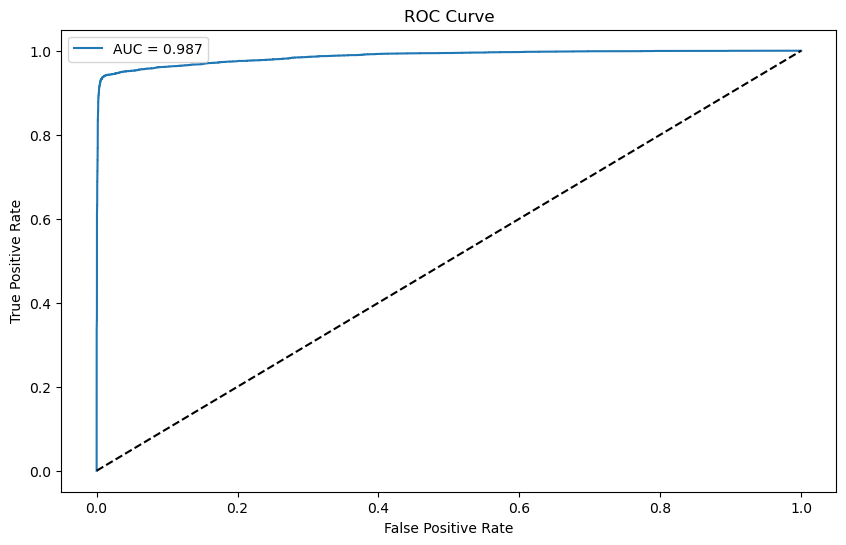

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

val_probs = model.predict(X_val, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_val, val_probs)
print(f"\nROC-AUC: {roc_auc:.4f}")

# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_val, val_probs)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Full AUC: 0.781889841225581


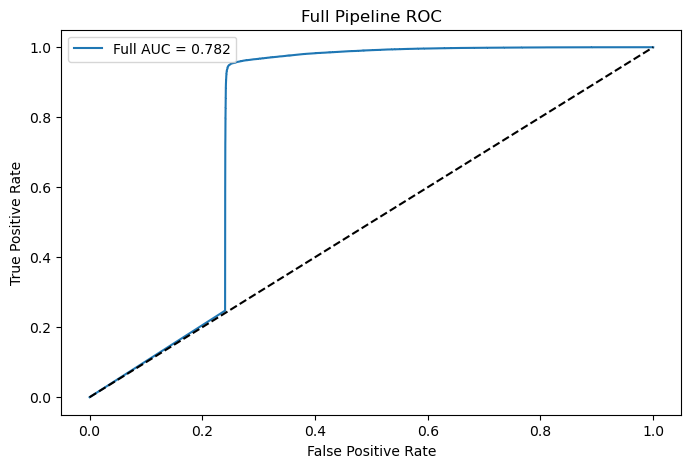

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve

# Предсказания для всего train
full_train_preds = predict_full(tr)      # та самая функция с rule+model
full_train_true  = target.values

# Общий ROC-AUC
auc_full = roc_auc_score(full_train_true, full_train_preds)
fpr, tpr, _ = roc_curve(full_train_true, full_train_preds)

print("Full AUC:", auc_full)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'Full AUC = {auc_full:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Full Pipeline ROC')
plt.legend()
plt.show()
